In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve
)


In [246]:
data=pd.read_csv("lending_club_loan_two.csv")
data.head(5)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [247]:
data.info()
data.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

(396030, 27)

#### 27 columns and 396030 rows in the dataset
#### Fully Paid - 318357, Charged Off - 77673 (19%)

employee length, employee title, purpose,revol_util and mort_acc have unequal values

### Data Analysis

In [248]:
data['loan_status'].value_counts(dropna=False)
data['loan_status'].value_counts().hvplot.bar(title="Loan Status Counts", xlabel='Loan Status', ylabel='Count',width=500, height=350)

:Bars   [index]   (loan_status)

<AxesSubplot:>

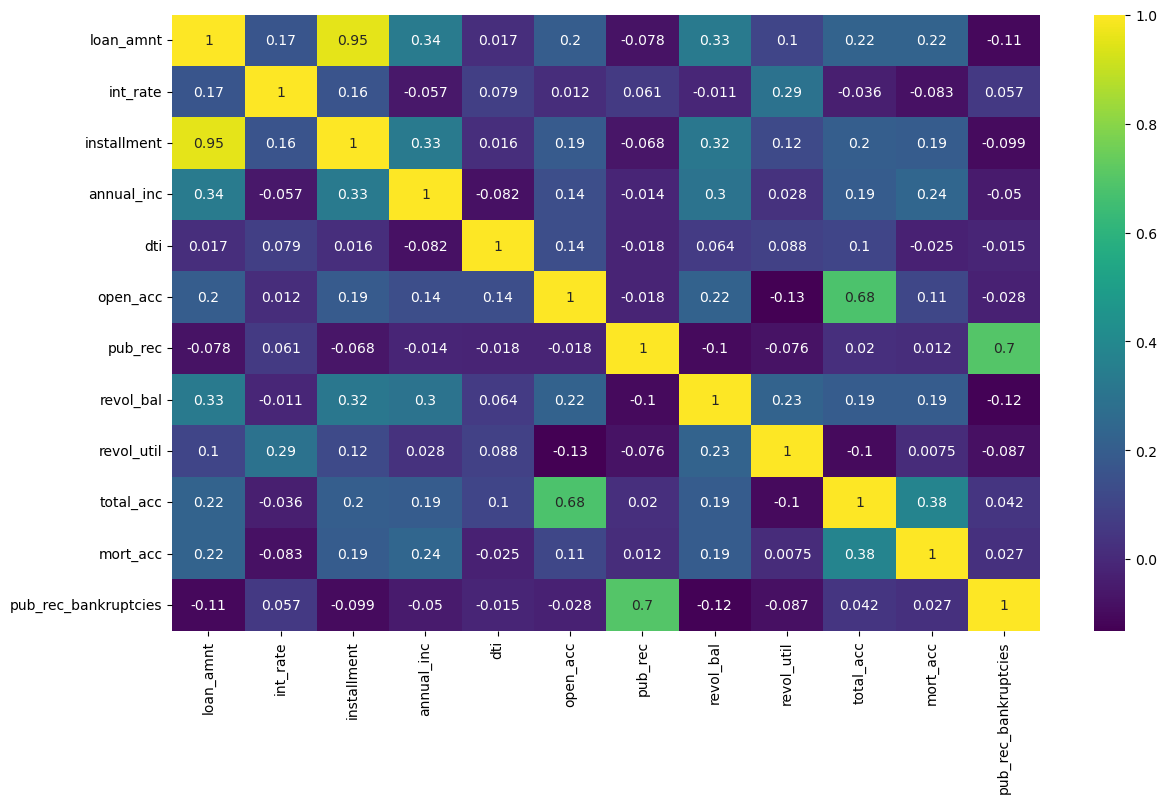

In [249]:
plt.figure(figsize=(14, 8))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

### Highest Correlation:
* Loan amt and installment
* annual income and loan amount
* loan amt and revolving balance

#### We plot feature vs loan status to understand how every feature effects their respective loan status 

In [250]:
installment = data.hvplot.hist(
    y='installment', by='loan_status', subplots=False, 
    width=350, height=400, bins=50, alpha=0.4, 
    title="Installment by Loan Status", 
    xlabel='Installment', ylabel='Counts', legend='top'
)
loan_amt = data.hvplot.hist(
    y='loan_amnt', by='loan_status', subplots=False, 
    width=350, height=400, bins=50, alpha=0.4, 
    title="Loan amount by Loan Status", 
    xlabel='Loan amount', ylabel='Counts', legend='top'
)
installment + loan_amt

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [installment]   (installment_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [loan_amnt]   (loan_amnt_count)

In [251]:
int_rate = data.hvplot.hist(
    y='int_rate', by='loan_status', alpha=0.3, width=350, height=400,
    title="Loan Status by Interest Rate", xlabel='Interest Rate', ylabel='Loans Counts', 
    legend='top'
)

annual_inc = data.hvplot.hist(
    y='annual_inc', by='loan_status', bins=50,alpha=0.3, width=350, height=400,
    title="Loan Status by Annual Income", xlabel='Annual Income', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

int_rate + annual_inc

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [int_rate]   (int_rate_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [annual_inc]   (annual_inc_count)

In [252]:
data['annual_inc'].describe()
data[data.annual_inc <= 200000].hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=500, height=400,
    title="Loan Status by Annual Income (<= 200000/Year)", 
    xlabel='Annual Income', ylabel='Loans Counts', legend='top'
).opts(xrotation=45)

:NdOverlay   [loan_status]
   :Histogram   [annual_inc]   (annual_inc_count)

In [253]:
print(data.loc[data.annual_inc >= 1000000, 'loan_status'].value_counts())


data.loc[data.annual_inc >= 250000, 'loan_status'].value_counts()


Fully Paid     65
Charged Off    10
Name: loan_status, dtype: int64


Fully Paid     3509
Charged Off     568
Name: loan_status, dtype: int64

As interest rates increases the percentage of fully paid decreases and majority are charged off.
People with lower annual income seems to not pay back their loans

In [254]:
data['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [255]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'home_ownership'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'home_ownership'].value_counts().hvplot.bar()

home_ownership_count = (fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=90)
home_ownership_count

:Overlay
   .Bars.Home_ownership.I  :Bars   [index]   (home_ownership)
   .Bars.Home_ownership.II :Bars   [index]   (home_ownership)

In [256]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
data.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

since the number of 'any' 'none' is very less we have combined it with 'other'

In [257]:
print(data['verification_status'].value_counts())
data['purpose'].value_counts()

Verified           139563
Source Verified    131385
Not Verified       125082
Name: verification_status, dtype: int64


debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64

In [258]:
data['emp_title'].value_counts()[:20]

Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
Supervisor                  1830
Sales                       1638
Project Manager             1505
Owner                       1410
Driver                      1339
Office Manager              1218
manager                     1145
Director                    1089
General Manager             1074
Engineer                     995
teacher                      962
driver                       882
Vice President               857
Operations Manager           763
Administrative Assistant     756
Accountant                   748
Name: emp_title, dtype: int64

In [259]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])


fully_paid = data.loc[data['loan_status']=='Fully Paid', 'issue_d'].hvplot.hist(bins=35) 
charged_off = data.loc[data['loan_status']=='Charged Off', 'issue_d'].hvplot.hist(bins=35)

# fully_paid * charged_off
loan_issue_date = (fully_paid * charged_off).opts(
    title="Loan Status by Loan Issue Date", xlabel='Loan Issue Date', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'earliest_cr_line'].hvplot.hist(bins=35) 
charged_off = data.loc[data['loan_status']=='Charged Off', 'earliest_cr_line'].hvplot.hist(bins=35)

earliest_cr_line = (fully_paid * charged_off).opts(
    title="Loan Status by earliest_cr_line", xlabel='earliest_cr_line', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

loan_issue_date + earliest_cr_line

:Layout
   .Overlay.I  :Overlay
      .Histogram.I  :Histogram   [issue_d]   (issue_d_count)
      .Histogram.II :Histogram   [issue_d]   (issue_d_count)
   .Overlay.II :Overlay
      .Histogram.I  :Histogram   [earliest_cr_line]   (earliest_cr_line_count)
      .Histogram.II :Histogram   [earliest_cr_line]   (earliest_cr_line_count)

In [260]:
title = "Loan Status by Total credit revolving balance"

revol_bal = data.hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top'
)

title = "Loan Status by Total credit revolving balance (<250000)"

sub_revol_bal = data[data['revol_bal']<=250000].hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top', shared_axes=False
).opts(xrotation=45)

revol_bal + sub_revol_bal

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)

In [261]:
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [262]:
data.corr()['loan_status'].drop('loan_status').sort_values().hvplot.barh(
    width=600, height=400, 
    title="Correlation between Loan status and Numeric Features", 
    ylabel='Correlation', xlabel='Numerical Features', 
)

:Bars   [index]   (loan_status)

##### Data preprocessing

In [263]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1755' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [264]:
data.dropna(inplace=True)

In [265]:
data.shape

(335868, 27)

In [266]:
data.drop('emp_title', axis=1, inplace=True)
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')
data.drop('emp_length', axis=1, inplace=True)

10+ years years in this position:
1    0.813507
0    0.186493
Name: loan_status, dtype: float64
4 years years in this position:
1    0.800098
0    0.199902
Name: loan_status, dtype: float64
< 1 year years in this position:
1    0.784623
0    0.215377
Name: loan_status, dtype: float64
6 years years in this position:
1    0.804927
0    0.195073
Name: loan_status, dtype: float64
9 years years in this position:
1    0.793352
0    0.206648
Name: loan_status, dtype: float64
2 years years in this position:
1    0.798968
0    0.201032
Name: loan_status, dtype: float64
3 years years in this position:
1    0.797326
0    0.202674
Name: loan_status, dtype: float64
8 years years in this position:
1    0.796914
0    0.203086
Name: loan_status, dtype: float64
7 years years in this position:
1    0.80211
0    0.19789
Name: loan_status, dtype: float64
5 years years in this position:
1    0.800383
0    0.199617
Name: loan_status, dtype: float64
1 year years in this position:
1    0.792818
0    0.207182


Realistically there are too many unique job titles to try to convert this to a dummy variable feature. Let's remove that emp_title column.
Charge off rates are extremely similar across all employment lengths. So we are going to drop the `emp_length` column.

In [267]:
data.purpose.value_counts().head()


debt_consolidation    204310
credit_card            72648
home_improvement       19637
other                  16194
major_purchase          6367
Name: purpose, dtype: int64

In [268]:
data.title.value_counts().head()


Debt consolidation         144270
Credit card refinancing     48438
Home improvement            14154
Other                       11951
Debt Consolidation           8986
Name: title, dtype: int64

In [269]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data.zip_code.value_counts()
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)
data.drop('title', axis=1, inplace=True)
data.drop('grade', axis=1, inplace=True)
data.drop('address', axis=1, inplace=True)
data.drop('issue_d', axis=1, inplace=True)
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)


title and purpose is almost similar hence going to drop title feature

In [270]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [271]:
total_acc_avg = data.groupby(by='total_acc').mean().mort_acc
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [272]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(225031, 79)
(110837, 79)


removing outliers

In [273]:
print(train[train['dti'] <= 50].shape)
print(train.shape)
print(train.shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)


(225017, 79)
(225031, 79)
(225031, 79)
(222668, 79)


In [274]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status
X_train.dtypes

loan_amnt                      float64
term                             int64
int_rate                       float64
installment                    float64
annual_inc                     float64
                                ...   
application_type_INDIVIDUAL      uint8
application_type_JOINT           uint8
home_ownership_OTHER             uint8
home_ownership_OWN               uint8
home_ownership_RENT              uint8
Length: 78, dtype: object

In [275]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>)

In [ ]:
bestfeat = mutual_info_classif(X_train, y_train)
plt.subplots(1, figsize=(26, 1))
sns.heatmap(bestfeat[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(data.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>)